In [52]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def extract_metric(report_path, metric_name):
    with open(report_path, 'r') as file:
        content = file.read()
        # Adjusted regex pattern to be more flexible with spaces and optional percentage sign
        match = re.search(rf'{re.escape(metric_name)}\s*\[?\%?\]?\s*([\d.]+)', content)
        if match:
            return float(match.group(1))
        else:
            return None

def collect_agent_metrics(base_dir, agent_name):
    metrics = {
        'Collision Rate': [],
        'Success Rate': [],
        'Progression': [],
        'Avg. Number of Timesteps': [],
        'Avg. Absolute Path Error [m]': []
    }
    scenarios = []

    for test_scen in os.listdir(base_dir):
        test_scen_dir = os.path.join(base_dir, test_scen)
        if os.path.isdir(test_scen_dir):
            agent_dir_path = os.path.join(test_scen_dir, agent_name)
            report_path = os.path.join(agent_dir_path, 'report.txt')
            if os.path.exists(report_path):
                for metric_name in metrics.keys():
                    metric_value = extract_metric(report_path, metric_name)
                    if metric_value is not None:
                        metrics[metric_name].append(metric_value)
                scenarios.append(test_scen)
    
    return metrics, scenarios


plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

def visualize_percentages_together_one_agent(metrics, scenarios):
    metric_names = ['Success Rate', 'Collision Rate', 'Progression']
    percentage_metrics = {name: metrics[name] for name in metric_names}

    x = np.arange(len(scenarios))
    width = 0.2
    patterns = ['/', '\\', '|'] # or "o" or "." 

    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, (metric_name, values) in enumerate(percentage_metrics.items()):
        ax.bar(x + width*i, values, width, label=metric_name) #,hatch=patterns[i])

    ax.set_xlabel('Scenarios')
    ax.set_ylabel('Percentage')
    ax.set_xticks(x + width)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def visualize_duration_one_agent(metrics, scenarios):
    metric_name = 'Avg. Number of Timesteps'
    duration_values = np.array(metrics[metric_name])/1000

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(scenarios, duration_values, color='skyblue')#, hatch='o')
    ax.set_xlabel('Scenarios')
    ax.set_ylabel('Avg. Time (s)')
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_path_deviance_one_agent(metrics, scenarios):
    metric_name = 'Avg. Absolute Path Error [m]'
    path_deviance_values = metrics[metric_name]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(scenarios, path_deviance_values, color='skyblue')#, hatch='.')
    ax.set_xlabel('Scenarios')
    ax.set_ylabel(metric_name)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

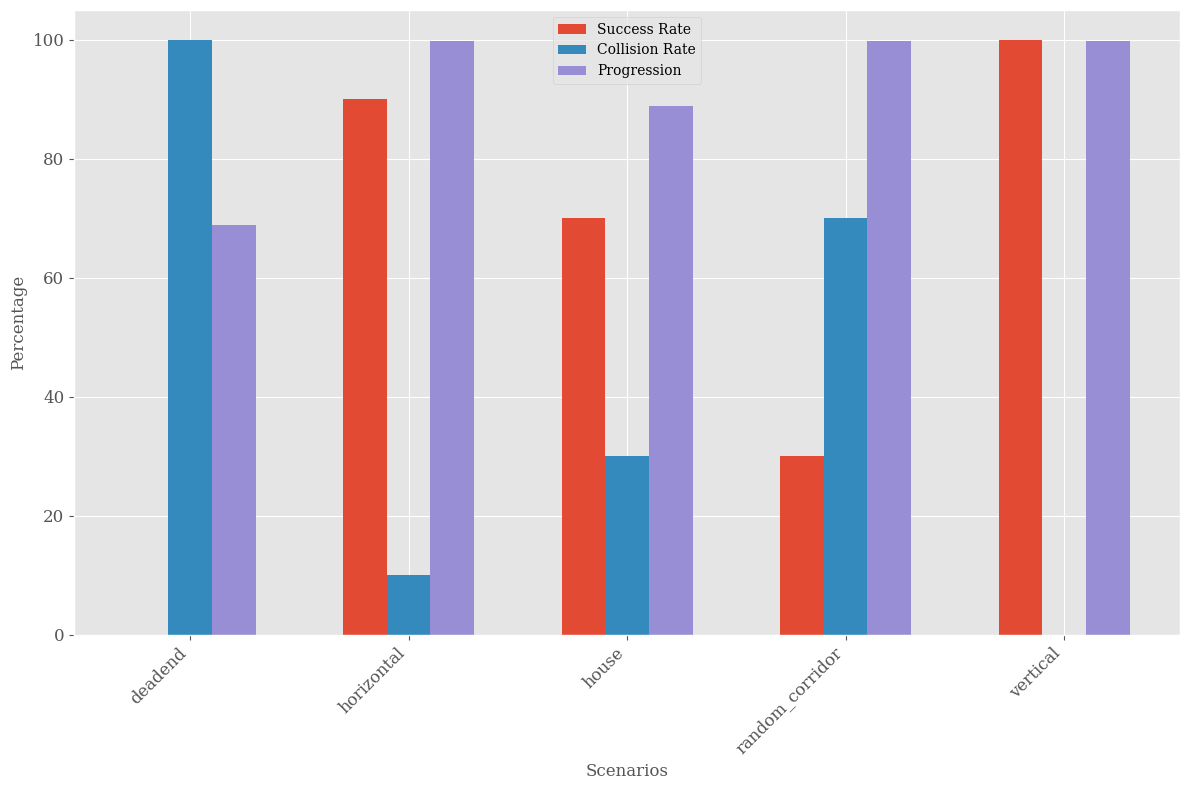

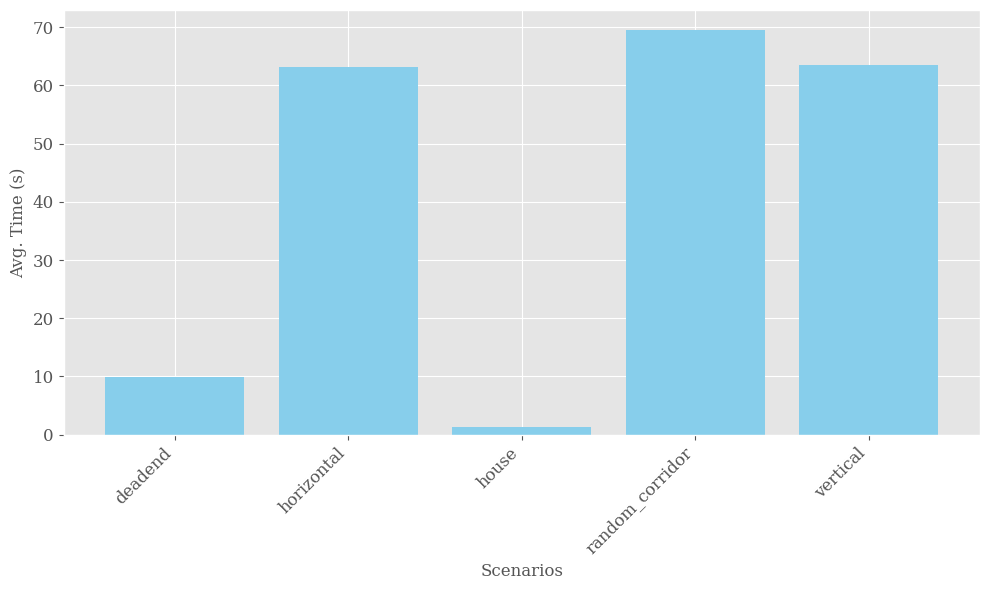

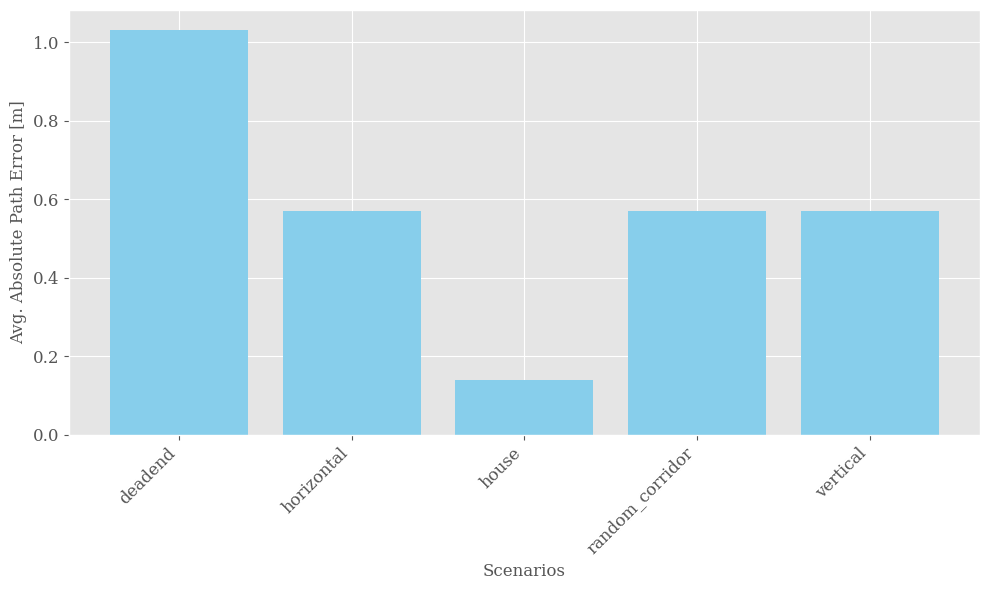

In [54]:
exp_id = 19
trained_scen = "expert"
agent_name = "test_agent_model_170000" 

base_dir = f'log/LV_VAE_MESH-v0/Experiment {exp_id}/{trained_scen}/results_gen'

metrics, scenarios = collect_agent_metrics(base_dir, agent_name)

visualize_percentages_together_one_agent(metrics, scenarios)
visualize_duration_one_agent(metrics, scenarios)
visualize_path_deviance_one_agent(metrics, scenarios)
